In [132]:
from dataclasses import dataclass

import numpy as np
import random
from typing import List, Tuple

import matplotlib.pyplot as plt

In [258]:
@dataclass
class Point:
    vector2f: np.ndarray

    def __init__(self, x, y):
        self.vector2f = np.array([x, y])

    def __getitem__(self, index):
        return self.vector2f[index]

    def __len__(self):
        return len(self.vector2f)
    
    @property
    def x(self):
        return self.vector2f[0]
    
    @property
    def y(self):
        return self.vector2f[1]


class Line:
    """Line in ax + by + c = 0 form"""
    vector3f: np.ndarray

    def __init__(self, a, b, c):
        self.vector3f = np.array([a, b, c])

    @property
    def a(self):
        return self.vector3f[0]
    @property
    def b(self):
        return self.vector3f[1]
    @property
    def c(self):
        return self.vector3f[2]

    @classmethod
    def from_points(cls, point1, point2):
        return cls(*np.cross(np.array([*point1, 1]), np.array([*point2, 1])))
    
    def intersection(self, other):
        cross = np.cross(self.vector3f, other.vector3f)
        return Point(*cross[:2] / cross[2])


@dataclass
class Box:
    x1: float
    y1: float
    x2: float
    y2: float

    def __hash__(self):
        return hash((self.x1, self.y1, self.x2, self.y2))


Room = Door = Wall = Box


@dataclass
class Agent:
    x: float
    y: float
    orientation: float # In degrees
    radius: float


def line_from_points(point1: np.array, point2: np.array):
    return np.cross(np.array([*point1, 1]), np.array([*point2, 1]))


def line_intersection(line1: np.array, line2: np.array):
    cross = np.cross(line1, line2)
    if cross[2] == 0:
        return None
    return cross[:2] / cross[2]

In [259]:
# Create two lines
line1 = Line.from_points(Point(0, 0), Point(1, 1))
line2 = Line.from_points(Point(0, 1), Point(1, 0))

# Find the intersection
intersection = line1.intersection(line2)

# Print the intersection point
print(f"Intersection point: {intersection}")


Intersection point: Point(vector2f=array([0.5, 0.5]))


In [948]:
class RoombaEnv():
    def __init__(
            self,
            width=10,
            height=10,
            min_room_size=2,
            max_rooms=10,
            door_width=1,
            turn_speed=30,
            move_speed=0.2,
            min_door_margin=0.5,
            wall_width=0.1,
        ):
        """A 2D environment with a circular agent and connected rooms.

        Args:
            width (float): The width of the environment.
            height (float): The height of the environment.
            min_room_size (float): The minimum size of a room.
            max_rooms (int): The maximum number of rooms in the environment.
            door_width (float): The width of the doors.
            turn_speed (float): The speed in degrees at which the agent turns.
            move_speed (float): The speed at which the agent moves.
        """
        assert door_width + 2 * min_door_margin <= min_room_size, \
            "Door width + minimum door margin must be less than the minimum room size."
        
        self.width = width
        self.height = height
        self.min_room_size = min_room_size
        self.max_rooms = max_rooms
        self.door_width = door_width
        self.turn_speed = turn_speed
        self.move_speed = move_speed
        self.min_door_margin = min_door_margin
        self.wall_width = wall_width
        
        self.reset()

    def reset(self):
        self.rooms, self.doors = self.create_layout(max_rooms=self.max_rooms)
        self.walls = self._convert_layout_to_walls(self.rooms, self.doors)
        self.agent = self._spawn_agent()

    def step(self, action):
        # Move forward
        if action == 0:
            self._move_forward()
        # Turn left
        elif action == 1:
            self.agent.orientation = (self.agent.orientation + self.turn_speed) % 360
        # Turn right
        elif action == 2:
            self.agent.orientation = (self.agent.orientation - self.turn_speed) % 360

    def _move_forward(self):
        self.move_agent(self.agent, self.agent.orientation, self.walls, self.move_speed)


    def move_agent(self, agent, direction_angle, walls, speed, angle_in_degrees=True):
        # Convert direction angle to direction vector
        if angle_in_degrees:
            direction_angle = np.radians(direction_angle)
        direction_vector = np.array([np.cos(direction_angle), np.sin(direction_angle)])
        
        # Normalize direction vector
        if np.linalg.norm(direction_vector) > 0:
            direction_vector = direction_vector / np.linalg.norm(direction_vector)
        
        # Calculate new position
        new_x = agent.x + direction_vector[0] * speed
        new_y = agent.y + direction_vector[1] * speed

        # Check for collisions with walls
        for wall in walls:
            direction_vector = self._adjust_for_collision(agent, new_x, new_y, direction_vector, wall)
            new_x = agent.x + direction_vector[0] * speed
            new_y = agent.y + direction_vector[1] * speed
            # if self.check_collision(agent, new_x, new_y, wall):
            #     # If a collision is detected, calculate sliding direction
            #     direction_vector = self.calculate_slide_vector(direction_vector, wall)
            #     new_x = agent.x + direction_vector[0] * speed
            #     new_y = agent.y + direction_vector[1] * speed
        
        # Update agent's position
        agent.x = new_x
        agent.y = new_y

    def _adjust_for_collision(self, agent, new_x, new_y, direction_vector, wall):
        # Vector representation of the wall
        wall_start = np.array([wall.x1, wall.y1])
        wall_end = np.array([wall.x2, wall.y2])
        agent_start = np.array([agent.x, agent.y])
        agent_end = np.array([new_x, new_y])

        wall_vec = wall_end - wall_start
        wall_len = np.linalg.norm(wall_vec)
        
        if wall_len == 0:
            return direction_vector
        else:
            # Unit vector along the wall
            wall_unit_vec = wall_vec / wall_len

        ### CHECK FOR COLLISION

        # Vector from wall start to agent's new position
        wall_to_agent_end_vec = agent_end - wall_start

        # Projection of agent vector onto the wall unit vector
        projection_length = np.clip(np.dot(wall_to_agent_end_vec, wall_unit_vec), 0, wall_len)

        # Find the closest point on the wall to the agent's new position
        closest_point = wall_start + projection_length * wall_unit_vec

        # Distance from the agent's new position to the closest point on the wall
        dist_to_nearest_wall = np.linalg.norm(agent_end - closest_point)

        # If no collision, then return the original direction vector
        if dist_to_nearest_wall > agent.radius:
            return direction_vector

        ### CALCULATE NEW DIRECTION VECTOR

        # wall_line = line_from_points(wall_start, wall_end)
        # agent_line = line_from_points(agent_start, agent_end)
        # intersection = line_intersection(wall_line, agent_line)
        # if intersection is None:
        #     return direction_vector

        # dist_to_wall = np.linalg.norm(intersection - (agent_start + agent.radius * direction_vector))
        # dist_to_wall = max(dist_to_wall, 0)

        # original_agent_dist = np.linalg.norm(agent_end - agent_start)
        # fraction_to_wall = dist_to_wall / original_agent_dist
        # fraction_after_wall = 1 - fraction_to_wall


        # Get distance from agent can move directly towards the wall until collision
        wall_to_agent_start_vec = agent_start - wall_start
        projection_length = np.clip(np.dot(wall_to_agent_start_vec, wall_unit_vec), 0, wall_len)
        closest_point = wall_start + projection_length * wall_unit_vec
        dist_to_nearest_wall = max(np.linalg.norm(agent_start - closest_point) - agent.radius, 0)

        wall_ortho_vec = np.array([wall_unit_vec[1], -wall_unit_vec[0]])
        # towards_wall_vector = wall_ortho_vec * np.dot(direction_vector, wall_ortho_vec)

        # original_agent_dist = np.linalg.norm(agent_end - agent_start)
        vec_to_ortho_endpoint = np.dot((agent_end - agent_start), wall_ortho_vec) * wall_ortho_vec
        dist_to_ortho_endpoint = np.linalg.norm(vec_to_ortho_endpoint)
        
        if dist_to_ortho_endpoint > 0:
            towards_wall_frac = dist_to_nearest_wall / dist_to_ortho_endpoint
        else:
            towards_wall_frac = 0
        towards_wall_vector = wall_ortho_vec * np.dot(direction_vector, wall_ortho_vec) * towards_wall_frac


        # Project the direction vector onto the wall unit vector
        slide_vector = wall_unit_vec * np.dot(direction_vector, wall_unit_vec)

        # Combine the slide vector with the original direction vector so that the agent
        # first hits the wall and then slides
        new_direction_vector = towards_wall_vector + slide_vector

        return new_direction_vector

    def _spawn_agent(self):
        room = random.choice(self.rooms)
        x_midpoint = (room.x1 + room.x2) / 2
        y_midpoint = (room.y1 + room.y2) / 2
        agent = Agent(x=x_midpoint, y=y_midpoint, orientation=0, radius=0.25)
        return agent

    def _split_room(self, room: Room, doors: List[Door]) -> Tuple[Tuple[Room, Room], Door]:
        if (room.x2 - room.x1) > (room.y2 - room.y1):  # Split vertically
            if room.x2 - room.x1 > 2 * self.min_room_size:  # Ensure there's enough space to split
                split_line = random.uniform(room.x1 + self.min_room_size, room.x2 - self.min_room_size)

                wall = Wall(split_line, room.y1, split_line, room.y2)
                if self._check_wall_door_intersection(wall, doors):
                    return (room, None), None
                
                room1 = Room(room.x1, room.y1, split_line, room.y2)
                room2 = Room(split_line, room.y1, room.x2, room.y2)
                door = self._place_door(room1, room2)
            else:
                return (room, None), None
        else:  # Split horizontally
            if room.y2 - room.y1 > 2 * self.min_room_size:  # Ensure there's enough space to split
                split_line = random.uniform(room.y1 + self.min_room_size, room.y2 - self.min_room_size)

                wall = Wall(room.x1, split_line, room.x2, split_line)
                if self._check_wall_door_intersection(wall, doors):
                    return (room, None), None
                
                room1 = Room(room.x1, room.y1, room.x2, split_line)
                room2 = Room(room.x1, split_line, room.x2, room.y2)
                door = self._place_door(room1, room2)
            else:
                return (room, None), None
        return (room1, room2), door
    
    def _check_wall_door_intersection(
            self,
            wall: Wall,
            doors: List[Door],
        ) -> bool:
        is_horizontal = wall.y1 == wall.y2
        for door in doors:
            if is_horizontal:
                door_midpoint = (door.y1 + door.y2) / 2
                overlap = (
                    door.x1 == door.x2 and # Is a vertical door
                    abs(door_midpoint - wall.y1) < (self.door_width / 2 + self.min_door_margin) and # Door vertically intersects with the split line
                    door.x1 >= wall.x1 and door.x1 <= wall.x2 # Door is within the wall
                )
                if overlap:
                    return door
            else:
                door_midpoint = (door.x1 + door.x2) / 2
                overlap = (
                    door.y1 == door.y2 and # Is a horizontal door
                    abs(door_midpoint - wall.x1) < (self.door_width / 2 + self.min_door_margin) and # Door horizontally intersects with the split line
                    door.y1 >= wall.y1 and door.y1 <= wall.y2 # Door is within the wall
                )
                if overlap:
                    return door
        return None
    
    def _get_wall_door_overlap(
            self,
            wall: Wall,
            doors: List[Door],
        ) -> bool:
        is_horizontal = wall.y1 == wall.y2
        for door in doors:
            if is_horizontal:
                overlap = (
                    door.y1 == door.y2 and # Is a horizontal door
                    door.y1 == wall.y1 and # Is it on the same x-axis
                    door.x1 >= wall.x1 and door.x2 <= wall.x2 # Door is within the wall
                )
                if overlap:
                    return door
            else:
                overlap = (
                    door.x1 == door.x2 and # Is a vertical door
                    door.x1 == wall.x1 and # Is it on the same y-axis
                    door.y1 >= wall.y1 and door.y2 <= wall.y2 # Door is within the wall
                )
                if overlap:
                    return door
        return None
    
    def _place_door(self, room1: Room, room2: Room) -> Door:
        is_horizontal = room1.y1 == room2.y2 or room1.y2 == room2.y1
        if is_horizontal:
            door_position = random.uniform(
                room1.x1 + self.min_door_margin,
                room1.x2 - self.min_door_margin - self.door_width,
            )
            door = Door(
                door_position, room1.y2,
                door_position + self.door_width, room2.y1,
            )
        else:
            door_position = random.uniform(
                room1.y1 + self.min_door_margin,
                room1.y2 - self.min_door_margin - self.door_width,
            )
            door = Door(
                room1.x2, door_position,
                room2.x1, door_position + self.door_width,
            )
        return door
    
    def _convert_layout_to_walls(self, rooms: List[Room], doors: List[Door]) -> List[Wall]:
        """Convert the rooms and doors to walls, taking into account door intersections.

        For each wall, check every door for an intersection.
        If there is an intersection, add the two walls on either side.
        If no intersection, add the wall.
        """
        final_walls = set()
        for room in rooms:
            walls = [
                Wall(room.x1, room.y1, room.x2, room.y1),
                Wall(room.x1, room.y2, room.x2, room.y2),
                Wall(room.x1, room.y1, room.x1, room.y2),
                Wall(room.x2, room.y1, room.x2, room.y2),
            ]
            for wall in walls:
                door = self._get_wall_door_overlap(wall, doors)
                if door:
                    final_walls.add(Wall(wall.x1, wall.y1, door.x1, door.y1))
                    final_walls.add(Wall(door.x2, door.y2, wall.x2, wall.y2))
                else:
                    final_walls.add(wall)
        return list(final_walls)

    def create_layout(self, max_rooms=10, max_tries=5) -> Tuple[List[Room], List[Door]]:
        rooms = [Room(0, 0, self.width, self.height)]
        doors = []
        curr_tries = 0
        while len(rooms) < max_rooms and curr_tries < max_tries:
            room = random.choice(rooms)
            rooms.remove(room)
            (room1, room2), door = self._split_room(room, doors)
            if room2:  # Only add the rooms if the split was successful
                rooms.append(room1)
                rooms.append(room2)
                if door:
                    doors.append(door)
                curr_tries = 0
            else:
                rooms.append(room1)  # If split fails, put the room back
                curr_tries += 1
        return rooms, doors

    def draw_layout(self):
        fig, ax = plt.subplots()
        for wall in self.walls:
            ax.plot([wall.x1, wall.x2], [wall.y1, wall.y2], color='black', linewidth=2)
        circle = plt.Circle((self.agent.x, self.agent.y), radius=self.agent.radius, color='blue', fill=True)
        ax.add_patch(circle)
        arrow_length = self.agent.radius
        arrow_x = self.agent.x + arrow_length * np.cos(np.radians(self.agent.orientation)) / 2
        arrow_y = self.agent.y + arrow_length * np.sin(np.radians(self.agent.orientation)) / 2
        ax.arrow(self.agent.x, self.agent.y, arrow_x - self.agent.x, arrow_y - self.agent.y, head_width=0.2, head_length=0.3, fc='red', ec='red')
        plt.xlim(0, max(room.x2 for room in self.rooms))
        plt.ylim(0, max(room.y2 for room in self.rooms))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

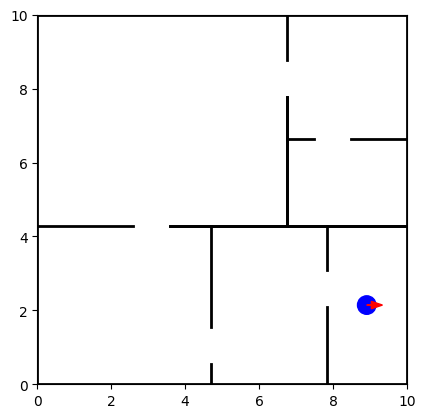

In [949]:
env = RoombaEnv(min_room_size=2)
env.draw_layout()

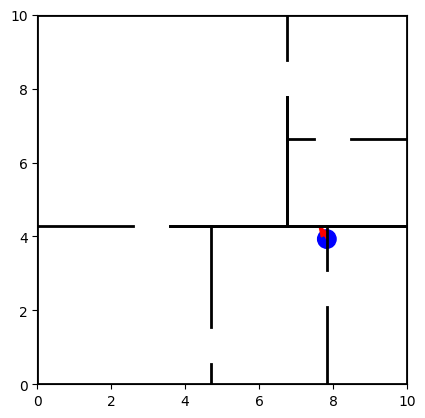

In [1088]:
env.step(0)
env.draw_layout()

In [213]:
env.rooms

[Box(x1=4.032669564900025, y1=6.459620375641276, x2=7.6822531554318445, y2=10),
 Box(x1=7.6822531554318445, y1=6.459620375641276, x2=10, y2=10),
 Box(x1=5.461721161015726, y1=0, x2=7.683476011112585, y2=3.908077076215179),
 Box(x1=7.683476011112585, y1=0, x2=10, y2=3.908077076215179),
 Box(x1=5.461721161015726, y1=3.908077076215179, x2=7.949932107227409, y2=6.459620375641276),
 Box(x1=7.949932107227409, y1=3.908077076215179, x2=10, y2=6.459620375641276),
 Box(x1=2.001512169966329, y1=6.459620375641276, x2=4.032669564900025, y2=10),
 Box(x1=0, y1=6.459620375641276, x2=2.001512169966329, y2=10),
 Box(x1=0, y1=0, x2=5.461721161015726, y2=4.04723765892196),
 Box(x1=0, y1=4.04723765892196, x2=5.461721161015726, y2=6.459620375641276)]